*Stanislav Borysov [stabo@dtu.dk], DTU Management*
# Advanced Business Analytics

## Deep Learning - Extremely Brief Introduction in Keras (Part 2: FCNN, CNN, RNN)

Deep learning recently caused a lot of hype. Some people call it AI, some just sophisticated "curve fitting". However, the fact is that it pushed state-of-the-art performance in multiple fields, especially, in computer vision, natural language processing, and speech recognition. It also started gaining popularity in business analytics where the data are often high dimensional and have a rich structure, like spatiotemporal data from smart mobility (https://www.kaggle.com/c/nyc-taxi-trip-duration/kernels). Today, we'll focus on multi-layer neural networks in Keras — one of the most popular deep learning frameworks designed for both research and production.

Being quite general and flexible, an NN has become a very popular and powerful model with a wide range of applications. One of its main strengths is the ability to process information hierarchically, automatically capturing new levels of abstraction in the data, effectively dealing with the curse of dimensionality. This problem arises because, with the growth of dimensionality (i.e., the number of features) of the data, the volume of a unit sphere in this space growths exponentially. As a consequence, to explore this volume and provide reasonable statistical estimations, a model requires exponentially more data samples. One of the known approaches to tackle this problem is dimensionality reduction, which assumes that there are only a few important dimensions, which can be represented as (often nonlinear) combinations of the initial ones. An NN is believed to do it automatically, where each following layer learns new low-dimensional representations of the data.

For example, consider a document topic classification problem given scanned handwritten text as an input. It would be almost impossible to perform this semantic analysis directly on the raw pixel intensities. Instead, an NN detects strokes and curves first, then tries to identify letters, which in turn constitute words. This can be achieved thanks to the layered structure that theoretically can learn any complex mapping. We stress the word “theoretically” because it appears not so trivial to do it in practice. The main challenge is the training of an NN: Fitting its parameters essentially boils down to finding a minimum of a nonconvex function in a high (thousand- or even million-) dimensional space. Therefore, plain fully connected NNs are rarely used alone. Many different hybrid architectures of NNs tailored for different purposes have been proposed. A Convolutional Neural Network (CNN) and a Recurrent Neural Network (RNN) are the two most fundamental prototypes which can be found in almost all modern deep learning models.

<img src="ann.png">

### Part 1 - Multilayer Neural Networks in Keras

Keras is a useful package that provides a high-level interface to more advanced deep learning frameworks such as TensorFlow. It makes the life of a deep learning researcher much easier. 

https://keras.io/

"Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.

Use Keras if you need a deep learning library that:

- Allows for easy and fast prototyping (through user-friendliness, modularity, and extensibility).
- Supports both convolutional networks and recurrent networks, as well as combinations of the two.
- Runs seamlessly on CPU and GPU."

It has two ways of building models: Sequential and Functional APIs.

#### Sequential API

The Sequential API helps to start with something really simple. But let's import Keras and prepare the data first.

In [43]:
import keras

In this lecture, we will use the MNIST database of handwritten digits - the most popular toy example in deep learning. It has a training set of 60,000 examples and a test set of 10,000 examples of 28x28 pixels each. The digits have been size-normalized and centered in a fixed-size image.

In [44]:
from keras.datasets import mnist

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# input image dimensions
img_rows, img_cols = 28, 28
# number of labels
num_classes = 10

# conver images to 1D vectors
x_train = x_train.reshape(x_train.shape[0], img_rows * img_cols)
x_test = x_test.reshape(x_test.shape[0], img_rows * img_cols)

# correct data type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalize picxel values from [0, 255] to [0, 1]
x_train /= 255
x_test /= 255

Let's visualize some data samples first.

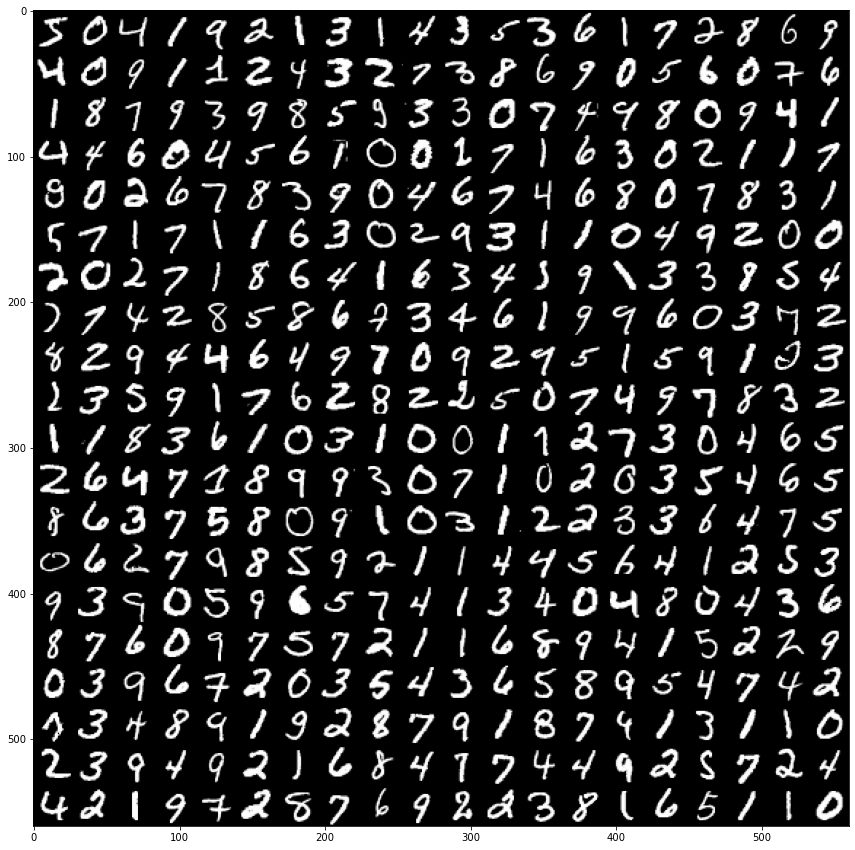

In [45]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline


def plot_digits(samples, n=20):
    ind = np.arange(len(samples))
    np.random.shuffle(ind)
    ind = ind[:n**2]
    figure = np.zeros((img_rows * n, img_cols * n))
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            indx = i * n + j
            sample = samples[indx]
            digit = sample.reshape(img_rows, img_cols)
            figure[i * img_rows: (i + 1) * img_rows,
                   j * img_cols: (j + 1) * img_cols] = digit
    plt.figure(figsize=(15, 15))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
    

plot_digits(x_train)

Although it is a relatively small dataset, training neural nets on it requires a lot of resources! So let's limit our data by 10,000 training and 5000 test samples, which is more suitable for a regular laptop.

In [46]:
n_train, n_test = 10000, 5000
x_train, y_train = x_train[:n_train], y_train[:n_train]
x_test, y_test = x_test[:n_test], y_test[:n_test]

We are going to solve the classification task: given an image, we need to predict which number is depicted on it. The labels in ```y_train``` and ```y_test``` are integers from 0 to 9. To use them in the ML, as usual, we need to convert them to the one-hot representation. For example, 0 becomes [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2 becomes [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], etc. Fortunately, Keras has a lot of convenient built-in functons.

In [47]:
num_classes = 10

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Great! Now we're ready to build our first "deep" neural network model using the Keras Sequential API.

A sequential model is specified using the ```Sequential()``` class.

In [48]:
from keras.models import Sequential

model = Sequential()

Let's add two densely connected layers to it consisting of 64 neurons each with ```tanh``` (hyperbolic tangent) nonlinearity. ```tanh``` is very similar to the sigmoid function used in logistic regression but produces values from -1 to 1 instead of [0, 1]. Another common choice is ```relu``` (Rectified Linear Unit) which is simply ReLU(x)=max(0,x).

<img src="activations.png">

In [49]:
from keras.layers import Dense

act_f = 'tanh' # There are a lot of them! See https://keras.io/activations/
hidden_neurons_n = 64

model.add(Dense(hidden_neurons_n, activation=act_f, input_shape=(img_rows * img_cols,))) # if no activation is specified, the layer becomes linear
model.add(Dense(hidden_neurons_n, activation=act_f))

The (final) output layer has ```softmax``` activation,

\begin{equation*}
\mathrm{softmax}(x_i) = \frac{\exp{x_i}}{\sum_i\exp{x_i}}.
\end{equation*}

The ```softmax``` function is a common choice for classification problems. Its output is normalized to 1 and represents probabilities for each class. For example, the output [0.1, 0.5, 0.1, 0.1, 0.1, 0.02, 0.02, 0.02, 0.02, 0.02] means that the NN thinks that (most probably) it is the digit "1".

In [50]:
model.add(Dense(num_classes, activation='softmax'))

Let's print a summary of our model.

In [51]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_33 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_34 (Dense)             (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


Even such a small NN with 2 hidden layers of 64 neurons each already has 55,050 parameters to optimize! You can now imagine how hard was to train deep NN 20 years ago...

OK, the final step before actual training is to compile our model to build a TensorFlow computational graph. We also need to specify an optimizer and loss function to use. Most optimizers for NN are based on the gradient descent algorithm, which helps to adjust parameters in order to minimize the difference between the NN predictions and actual ground truth. For regression tasks, the mean squared error is commonly used. For binary classification, we already used binary loss, the same as in the logistic regression. Cross-entropy loss is a generalization of the binary loss for multi-class problems. Note, that, in the case of NNs, we don't need to use "one-versus-all" or any other tricks, so the only one model is sufficient.

In [52]:
from keras.optimizers import RMSprop # there are a lot of them! See https://keras.io/optimizers/

optimizer = RMSprop() # you can also specify parameters of the otimizer, e.g. learning rate: RMSprop(lr=0.001)

In [53]:
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Huh, a lot of preparations... The modern deep learning frameworks require a lot of work to be done, however, it pays off with fast training which was almost unimaginable a few years ago.

The model can be trained using the ```fit()``` function. Some parameters to specify:
- ```batch_size``` - Calculating gradients over all the data is usually time-consuming. That's why the training data is usually divided into chunks called "mini-batches". Although the gradients, in this case, become approximate, on practice, it even helps to get better solutions, for example, by escaping from local minima of the loss function.
- ```epochs``` - Number of epochs to be used. One epoch corresponds to one pass through the whole train data. If ```batch_size=len(x_train)```, then one batch corresponds to one epoch.
- ```validation_data``` - The data to be used not for the test purposes on-the-fly (to detect overfitting).

Let's go!

In [54]:
batch_size = 128
epochs = 10

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, # show training process
                    validation_data=(x_test, y_test))

Train on 10000 samples, validate on 5000 samples
Epoch 1/10
10000/10000 [==============================] - 0s 34us/step - loss: 0.7723 - accuracy: 0.8053 - val_loss: 0.5552 - val_accuracy: 0.8342
Epoch 2/10
10000/10000 [==============================] - 0s 26us/step - loss: 0.3444 - accuracy: 0.9077 - val_loss: 0.4598 - val_accuracy: 0.8592
Epoch 3/10
10000/10000 [==============================] - 0s 27us/step - loss: 0.2714 - accuracy: 0.9242 - val_loss: 0.3899 - val_accuracy: 0.8842
Epoch 4/10
10000/10000 [==============================] - 0s 27us/step - loss: 0.2305 - accuracy: 0.9350 - val_loss: 0.3547 - val_accuracy: 0.8932
Epoch 5/10
10000/10000 [==============================] - 0s 25us/step - loss: 0.1998 - accuracy: 0.9432 - val_loss: 0.3419 - val_accuracy: 0.8966
Epoch 6/10
10000/10000 [==============================] - 0s 25us/step - loss: 0.1735 - accuracy: 0.9503 - val_loss: 0.3250 - val_accuracy: 0.9026
Epoch 7/10
10000/10000 [==============================] - 0s 26us/ste

Let's check the test accuracy one more time

In [55]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.30577557075023654
Test accuracy: 0.9074000120162964


Congrats, ~92% accuracy is not bad. Let's check if we can get better results with a larger number of epochs, different batch sizes, more/larger layers, different activation functions [https://keras.io/activations/], optimizers and their parameters like learning rate [https://keras.io/optimizers/] (These all are hyperparameters of the model!). Try to build and train a new model yourself now.

In [59]:
my_model = Sequential()

#tf.keras.activations.sigmoid(x)

act_f = 'sigmoid' # There are a lot of them! See https://keras.io/activations/
hidden_neurons_n = 64

model.add(Dense(hidden_neurons_n, activation=act_f, input_shape=(img_rows * img_cols,))) # if no activation is specified, the layer becomes linear
model.add(Dense(hidden_neurons_n, activation=act_f))

model.add(Dense(num_classes, activation='softmax'))

from keras.optimizers import RMSprop # there are a lot of them! See https://keras.io/optimizers/

optimizer = RMSprop() # you can also specify parameters of the otimizer, e.g. learning rate: RMSprop(lr=0.001)

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])


batch_size = 150
epochs = 5

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, # show training process
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 10000 samples, validate on 5000 samples
Epoch 1/5
10000/10000 [==============================] - 1s 59us/step - loss: 2.2887 - accuracy: 0.1450 - val_loss: 2.2608 - val_accuracy: 0.1958
Epoch 2/5
10000/10000 [==============================] - 0s 33us/step - loss: 2.2209 - accuracy: 0.3027 - val_loss: 2.1799 - val_accuracy: 0.3002
Epoch 3/5
10000/10000 [==============================] - 0s 33us/step - loss: 2.1055 - accuracy: 0.4131 - val_loss: 2.0391 - val_accuracy: 0.4508
Epoch 4/5
10000/10000 [==============================] - 0s 32us/step - loss: 1.9100 - accuracy: 0.4589 - val_loss: 1.8410 - val_accuracy: 0.4790
Epoch 5/5
10000/10000 [==============================] - 0s 32us/step - loss: 1.6796 - accuracy: 0.4894 - val_loss: 1.6634 - val_accuracy: 0.4554
Test loss: 1.6634209539413451
Test accuracy: 0.4553999900817871


#### Functional API

Let also familiarize ourselves with the Functional API. The Keras Functional API is the way to go for defining complex models, such as multi-output models, directed acyclic graphs, or models with shared layers. It's not very different from the Sequential but is more flexible. It requires to specify inputs and variables (tensors) passing to the layers explicitly.

In [60]:
from keras.layers import Input
from keras.models import Model

# This returns a tensor
inputs = Input(shape=(img_rows * img_cols,))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(hidden_neurons_n, activation=act_f)(inputs)
x = Dense(hidden_neurons_n, activation=act_f)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))  # starts training

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 10000 samples, validate on 5000 samples
Epoch 1/5
10000/10000 [==============================] - 0s 29us/step - loss: 1.9468 - accuracy: 0.5028 - val_loss: 1.6396 - val_accuracy: 0.6212
Epoch 2/5
10000/10000 [==============================] - 0s 23us/step - loss: 1.2784 - accuracy: 0.7370 - val_loss: 1.1213 - val_accuracy: 0.7196
Epoch 3/5
10000/10000 [==============================] - 0s 23us/step - loss: 0.8503 - accuracy: 0.8212 - val_loss: 0.8085 - val_accuracy: 0.8028
Epoch 4/5
10000/10000 [==============================] - 0s 25us/step - loss: 0.6053 - accuracy: 0.8694 - val_loss: 0.6362 - val_accuracy: 0.8372
Epoch 5/5
10000/10000 [==============================] - 0s 23us/step - loss: 0.4678 - accuracy: 0.8907 - val_loss: 0.5326 - val_accuracy: 0.8582
Test loss: 0.5325887247085571
Test accuracy: 0.8582000136375427


*Note that the results might be a bit different because parameters of the NN (weights and biases) are initialized randomly (by default) every time you specify a new model.*

Implement your model using the Functional API now.

In [ ]:
# ...

### Part 2 - Convolutional Neural Networks (CNNs)

A dense Neural Network is a very powerful model capable of approximating arbitrary nonlinear functions. At the same time, due to a large number of parameters, dense NNs are prone to overfitting. The enormous amount of data allowed for training them more efficiently nowadays. However, the real revolution began when special architectures of NNs, like CNNs and RNNs, came into play. Of course, the MNIST classification problem is relatively easy, so do not expect much gain from using a CNN instead of a plain fully connected (dense) NN.

A CNN architecture is believed to resemble a visual system of a brain. It consists of several convolutional-pooling layer pairs followed by a fully connected (dense) network. Neurons in a convolutional layer, which share their weights, scan through the input and produce multiple outputs of the same size as the input, also known as feature maps. The layer is called convolutional because it literarily performs convolutions of the input using adaptive kernels represented by a dense NN with one layer. A pooling layer downsamples these feature maps, using, for example, the ```max``` function over small contiguous regions, effectively reducing their dimensionality. These layers preserve spatial correlations and are capable of capturing the beforementioned hierarchical features, such as strokes, basic geometric shapes and so on. These layers are followed by a fully connected NN with a small number of hidden layers which is now able to solve the initially complex task (e.g. classification of cats versus not-cats).

<img src="cnn.png">

In Keras, the two special CNN layers are implemented using ```Conv2D``` and ```MaxPooling2D``` layers. To convert tensor to a 1D array, one can use ```Flatten``` layer.

In [61]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

As CNNs are primarily used for image processing tasks, these layers designed to use 3 channels (RGB) by default. As the MNIST data is grayscale, i.e. has only 1 channel, we need to specify this explicitly by reshaping the data.

In [62]:
from keras import backend as K

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Let's build our first CNN...

In [63]:
batch_size = 128
epochs = 10

kernels_n = 16
hidden_neurons_dense_n = 64
act_f = 'tanh'
kernel_size = (3, 3)
pool_size = (2, 2)

optimizer = RMSprop() # you can also specify parameters of the otimizer, e.g. learning rate: RMSprop(lr=0.001)


model = Sequential()
model.add(Conv2D(kernels_n, kernel_size=kernel_size,
                 activation=act_f,
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(hidden_neurons_dense_n, activation=act_f))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2704)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 64)                173120    
_________________________________________________________________
dense_51 (Dense)             (None, 10)                650       
Total params: 173,930
Trainable params: 173,930
Non-trainable params: 0
_________________________________________________________________


...and train it (Notice the number of the parameters!)

In [64]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 10000 samples, validate on 5000 samples
Epoch 1/10
10000/10000 [==============================] - 2s 153us/step - loss: 0.6314 - accuracy: 0.8378 - val_loss: 0.4332 - val_accuracy: 0.8732
Epoch 2/10
10000/10000 [==============================] - 1s 137us/step - loss: 0.2733 - accuracy: 0.9234 - val_loss: 0.3986 - val_accuracy: 0.8812
Epoch 3/10
10000/10000 [==============================] - 1s 139us/step - loss: 0.2028 - accuracy: 0.9433 - val_loss: 0.3478 - val_accuracy: 0.8906
Epoch 4/10
10000/10000 [==============================] - 1s 136us/step - loss: 0.1609 - accuracy: 0.9553 - val_loss: 0.2721 - val_accuracy: 0.9154
Epoch 5/10
10000/10000 [==============================] - 2s 163us/step - loss: 0.1289 - accuracy: 0.9613 - val_loss: 0.2265 - val_accuracy: 0.9290
Epoch 6/10
10000/10000 [==============================] - 2s 219us/step - loss: 0.1019 - accuracy: 0.9720 - val_loss: 0.2422 - val_accuracy: 0.9254
Epoch 7/10
10000/10000 [==============================] - 2s 22

Congrats, ~94% accuracy is not bad. Let's check if we can get a better result with a larger number of epochs, different batch size, more convolutional+pooling layers, more/larger dense layers, different activation functions [https://keras.io/activations/], optimizers and their parameters like learning rate [https://keras.io/optimizers/] (These all are hyperparameters of the model!). Try to build and train a new model yourself now using first Sequential and then Functional API.

In [39]:
# Sequential API

my_cnn = Sequential()
# ...

In [65]:
# Functional API

inputs = Input(shape=input_shape)
# ...

In [70]:
# CNN Functional API

inputs = Input(shape=input_shape) #búið að skilgreina input_shape ofar

batch_size = 128
epochs = 5

kernels_n = 16
hidden_neurons_dense_n = 64
act_f = 'tanh'
kernel_size = (3, 3)
pool_size = (2, 2)

# a layer instance is callable on a tensor, and returns a tensor
y = Dense(hidden_neurons_n, activation=act_f)(inputs)
y = Conv2D(kernels_n,
                 kernel_size = kernel_size,
                 activation = act_f,
                 input_shape = input_shape)(y)


y = MaxPooling2D(pool_size = pool_size)(y)
y = Flatten()(y)
y = Dense(hidden_neurons_dense_n, activation = act_f)(y)
predictions = Dense(num_classes, activation = 'softmax')(y)
# This creates a model that includes
# the Input layer and three Dense layers

my_cnn = Model(inputs=inputs, outputs=predictions)
my_cnn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
my_cnn.fit(x_train, y_train,
           batch_size = batch_size,
           epochs = epochs,
           verbose = 1,
           validation_data = (x_test, y_test))  # starts training

score = my_cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 10000 samples, validate on 5000 samples
Epoch 1/5
10000/10000 [==============================] - 14s 1ms/step - loss: 0.5046 - accuracy: 0.8513 - val_loss: 0.6604 - val_accuracy: 0.7660
Epoch 2/5
 3072/10000 [========>.....................] - ETA: 10s - loss: 0.2434 - accuracy: 0.9313

KeyboardInterrupt: 

In [ ]:
#RNN

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))  # starts training

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### Part 3 - Recurrent Neural Networks (RNNs)

An RNN has a quite simple underlying idea that appeared to be very powerful in practice. It is capable of storing the state of the network so it has some notion of memory. The output of an RNN depends not only on the current input but also on the all previous inputs. RNNs are used to process variable-length sequences with particular emphasis on time-series predictions, speech synthesis, and natural language processing applications. However, it turned out that the plain RNN implementation was not practical due to the limited ability to maintain its memory for a long time. To address this issue, many recurrent neuron types were proposed. The most popular ones are the Long Short-Term Memory (LSTM) cell and Gated Recurrent Unit (GRU), which contain special gates to control and propagate their internal (or hidden) state in a more efficient way. Similar ideas were also applied to regular feed-forward NNs leading to various network architectures such as Deep Residual Networks and Highway Networks, which are capable of propagating information (both forward and backward) through hundreds of layers. These networks become highly efficient for image processing tasks.

<img src="rnn.png">

Try to go through the examples. You are not supposed to understand everything, just to give you a flavor of how resource-demanding deep learning is.

**WARNING! IF YOU WANT TO RUN THE CODE! Both examples are too computationally demanding for a laptop. In the worst case, they can make your computer frozen. Save everything important if you want to run them!**

#### IMDB sentiment classification

[ https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py ]

In [ ]:
'''Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
# Notes
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

#### Text generation example
[ https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py ]

It'll almost for sure destroy your computer :) You need a quite good GPU for this.

In [ ]:
'''Example script to generate text from Nietzsche's writings.
At least 20 epochs are required before the generated text
starts sounding coherent.
It is recommended to run this script on GPU, as recurrent
networks are quite computationally intensive.
If you try this script on new data, make sure your corpus
has at least ~100k characters. ~1M is better.
'''

from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io

path = get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
with io.open(path, encoding='utf-8') as f:
    text = f.read().lower()
print('corpus length:', len(text))

# Too much for our laptops. Uncomment the following two lines if you want to run it!
#text = text[:1000]
#print("I've checked. It is too much for our laptops :( New corpus length:", len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y,
          batch_size=128,
          epochs=20,
          callbacks=[print_callback])